# Classify Steller Sea Lions

#### Method
Using blob detection to ID each sea lion coordinate, then extract 32x32 centered images. 
Sea Lions in the first image only and without negative examples** 

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import skimage.feature
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, Cropping2D
from keras.utils import np_utils
%matplotlib inline

Using TensorFlow backend.


### Initialize variables

In [5]:
classes = ["adult_males", "subadult_males", "adult_females", "juveniles", "pups"]

# sort files, if id is within the name, else float('inf)? 
file_names = os.listdir("../TrainSmall2.7z/Train/")
file_names = sorted(file_names, key=lambda 
                    item: (int(item.partition('.')[0]) if item[0].isdigit() else float('inf'), item)) 

# select a subset of files to run on
file_names = file_names[0:-1]

coordinates_df = pd.DataFrame(index=file_names, columns=classes)  # results store (training image preprocessing)

## Extract coordinates

Loop through files. Read image from both ```Train``` and ```TrainDotted```. Calculate the absolute difference between TRAIN and TRAINDOTTED. Masking out blackened regions from ```TrainDotted``` and ```Train``` (?). Bitwise or for the absolute image with both masks (?). Convert image to greyscale for blob detection (skimage blob_log).

Blob processing

Retrieve the coordinates, get the center pixel color of each blob and match to the NOAA color blob sets. Add to count and store into ```coordinates_df```

? = Look into

In [6]:
for filename in file_names:
    
    # read the Train and Train Dotted images
    image_1 = cv2.imread("../TrainSmall2.7z/TrainDotted/" + filename)
    image_2 = cv2.imread("../TrainSmall2.7z/Train/" + filename)

    # absolute difference between Train and Train Dotted
    image_3 = cv2.absdiff(image_1,image_2)
    
    # mask out blackened regions from Train Dotted
    mask_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
    mask_1[mask_1 < 20] = 0
    mask_1[mask_1 > 0] = 255
    
    mask_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
    mask_2[mask_2 < 20] = 0
    mask_2[mask_2 > 0] = 255
    
    image_3 = cv2.bitwise_or(image_3, image_3, mask=mask_1)
    image_3 = cv2.bitwise_or(image_3, image_3, mask=mask_2) 
    
    # convert to grayscale to be accepted by skimage.feature.blob_log
    image_3 = cv2.cvtColor(image_3, cv2.COLOR_BGR2GRAY)
    
    # detect blobs
    blobs = skimage.feature.blob_log(image_3, min_sigma=3, max_sigma=4, num_sigma=1, threshold=0.02)
    
    adult_males = []
    subadult_males = []
    pups = []
    juveniles = []
    adult_females = [] 
    
    for blob in blobs:
        y, x, s = blob  # coordinates / blob

        g,b,r = image_1[int(y)][int(x)][:]  # pixel color from TrainDotted in the center of blob
        
        # decision tree to pick the class of the blob by looking at the color in Train Dotted
        if r > 200 and g < 50 and b < 50: # RED
            adult_males.append((int(x),int(y)))        
        elif r > 200 and g > 200 and b < 50: # MAGENTA
            subadult_males.append((int(x),int(y)))         
        elif r < 100 and g < 100 and 150 < b < 200: # GREEN
            pups.append((int(x),int(y)))
        elif r < 100 and  100 < g and b < 100: # BLUE
            juveniles.append((int(x),int(y))) 
        elif r < 150 and g < 50 and b < 100:  # BROWN
            adult_females.append((int(x),int(y)))
    
    # Write to dataframe 
    coordinates_df["adult_males"][filename] = adult_males
    coordinates_df["subadult_males"][filename] = subadult_males
    coordinates_df["adult_females"][filename] = adult_females
    coordinates_df["juveniles"][filename] = juveniles
    coordinates_df["pups"][filename] = pups

In [51]:
for filename in file_names[1:2]:
    
    # read the Train and Train Dotted images
    image_1 = cv2.imread("../noaa/TrainSmall2/TrainDotted/" + filename)
    image_2 = cv2.imread("../noaa/TrainSmall2/Train/" + filename)
    
    # absolute difference between Train and Train Dotted
    
    image_3 = cv2.absdiff(image_1,image_2)
    
    # mask out blackened regions from Train Dotted
    mask_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
    mask_1[mask_1 < 20] = 0
    mask_1[mask_1 > 0] = 255
    
    mask_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
    mask_2[mask_2 < 20] = 0
    mask_2[mask_2 > 0] = 255
    
    image_3 = cv2.bitwise_or(image_3, image_3, mask=mask_1)
    image_3 = cv2.bitwise_or(image_3, image_3, mask=mask_2) 
    
    # convert to grayscale to be accepted by skimage.feature.blob_log
    image_3 = cv2.cvtColor(image_3, cv2.COLOR_BGR2GRAY)
    
    # detect blobs
    blobs = skimage.feature.blob_log(image_3, min_sigma=3, max_sigma=4, num_sigma=1, threshold=0.02)
    
    adult_males = []
    subadult_males = []
    pups = []
    juveniles = []
    adult_females = [] 
    
    for blob in blobs:
        y, x, s = blob  # coordinates / blob

        g,b,r = image_1[int(y)][int(x)][:]  # pixel color from TrainDotted in the center of blob
        
        # decision tree to pick the class of the blob by looking at the color in Train Dotted
        if r > 200 and g < 50 and b < 50: # RED
            adult_males.append((int(x),int(y)))        
        elif r > 200 and g > 200 and b < 50: # MAGENTA
            subadult_males.append((int(x),int(y)))         
        elif r < 100 and g < 100 and 150 < b < 200: # GREEN
            pups.append((int(x),int(y)))
        elif r < 100 and  100 < g and b < 100: # BLUE
            juveniles.append((int(x),int(y))) 
        elif r < 150 and g < 50 and b < 100:  # BROWN
            adult_females.append((int(x),int(y)))
    
    # Write to dataframe 
    coordinates_df["adult_males"][filename] = adult_males
    coordinates_df["subadult_males"][filename] = subadult_males
    coordinates_df["adult_females"][filename] = adult_females
    coordinates_df["juveniles"][filename] = juveniles
    coordinates_df["pups"][filename] = pups
    '''

[[[125 113  95]
  [124 112  94]
  [124 112  94]
  ..., 
  [  2   4   6]
  [  6   1   3]
  [  5   5   6]]

 [[127 114  98]
  [126 113  97]
  [126 113  97]
  ..., 
  [  5   4   1]
  [ 11   5   3]
  [  9   2   0]]

 [[126 113  99]
  [127 114  98]
  [126 113  97]
  ..., 
  [  3   2   1]
  [  7   3   4]
  [  7   2   1]]

 ..., 
 [[  0   1   1]
  [  1   0   0]
  [  2   1   1]
  ..., 
  [  3   2   1]
  [  1   1   1]
  [  1   5   4]]

 [[  0   0   0]
  [  1   1   1]
  [  2   2   2]
  ..., 
  [  6   0   1]
  [  6   0   1]
  [  4   2   1]]

 [[  0   0   0]
  [  1   1   1]
  [  2   2   2]
  ..., 
  [  4   2   1]
  [ 10   1   3]
  [ 13   2   4]]]


In [9]:
cv2.imread('../TrainSmall2.7z/Train/41.jpg')

array([[[ 48, 113,  91],
        [ 49, 111,  89],
        [ 53, 110,  89],
        ..., 
        [ 88,  74,  62],
        [ 86,  74,  62],
        [ 80,  71,  58]],

       [[ 52, 116,  94],
        [ 52, 114,  92],
        [ 54, 111,  90],
        ..., 
        [ 89,  72,  63],
        [ 84,  72,  62],
        [ 82,  70,  60]],

       [[ 60, 122, 100],
        [ 59, 118,  97],
        [ 57, 113,  92],
        ..., 
        [ 86,  68,  61],
        [ 82,  66,  59],
        [ 79,  66,  58]],

       ..., 
       [[ 61, 104,  95],
        [ 53,  95,  88],
        [ 55,  97,  90],
        ..., 
        [130, 125, 110],
        [132, 125, 110],
        [131, 124, 109]],

       [[ 65, 104,  96],
        [ 59, 100,  92],
        [ 59, 100,  92],
        ..., 
        [129, 124, 109],
        [128, 123, 108],
        [131, 124, 109]],

       [[ 63, 100,  92],
        [ 61,  98,  90],
        [ 58,  97,  89],
        ..., 
        [126, 121, 106],
        [126, 121, 106],
        [130, 122,

### Extract 32x32 images

In [10]:
x = []
y = []

for filename in file_names:
    if filename.endswith('.jpg'):
        image = cv2.imread("../TrainSmall2.7z/Train/" + filename)
        
        # classes = ["adult_males", "subadult_males", "adult_females", "juveniles", "pups"]
        for lion_class in classes:
            for coordinates in coordinates_df[lion_class][filename]:
                thumb = image[coordinates[1]-16:coordinates[1]+16,coordinates[0]-16:coordinates[0]+16,:]
                if np.shape(thumb) == (32, 32, 3):
                    x.append(thumb)
                    y.append(lion_class)
x = np.array(x)
y = np.array(y)

### Plot examples

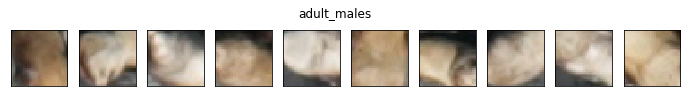

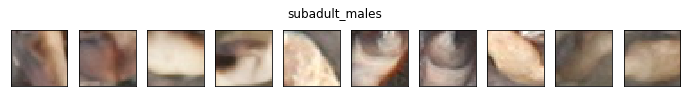

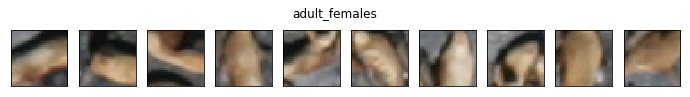

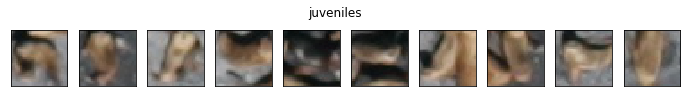

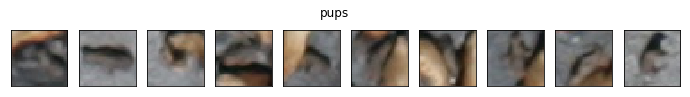

In [11]:
for lion_class in classes:
    f, ax = plt.subplots(1,10,figsize=(12,1.5))
    f.suptitle(lion_class)
    axes = ax.flatten()
    j = 0
    for a in axes:
        a.set_xticks([])
        a.set_yticks([])
        for i in range(j,len(x)):
            if y[i] == lion_class:
                j = i+1
                a.imshow(cv2.cvtColor(x[i], cv2.COLOR_BGR2RGB))
                break

### One hot encoding

In [12]:
encoder = LabelBinarizer()
encoder.fit(y)
y = encoder.transform(y).astype(float)

### Build Keras model

Conv (relu), MaxPool, Conv (relu), Flatten, Fully connected, Dropout, Fully connected(softmax)

In [13]:
model = Sequential()

model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(32,32,3)))


model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(5, activation='softmax'))
model.add(Dense(y.shape[1], activation='softmax'))
# 
# categorical_crossentropy
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [14]:
history = model.fit(x, y, epochs=20, validation_split=0.2, verbose=0)

### Results

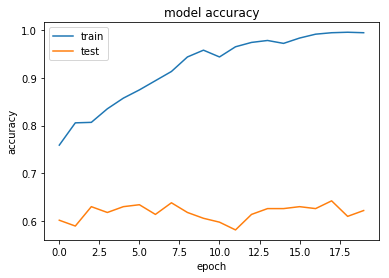

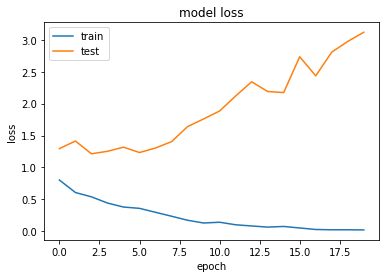

In [15]:
# http://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()